# Parse Apple Stock Prices from Web

In [11]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from pandas_datareader.data import DataReader


In [12]:
import warnings
warnings.simplefilter("ignore")

set_seed(455)
np.random.seed(455)


### Load Data

In [4]:
# Define time period

end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("AAPL", start, end)


[*********************100%%**********************]  1 of 1 completed


In [5]:
# Visualize raw dataset

dataset


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.594709,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,24.920444,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.590506,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.581202,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.606794,113715600
...,...,...,...,...,...,...
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300


### Split into Train and Test

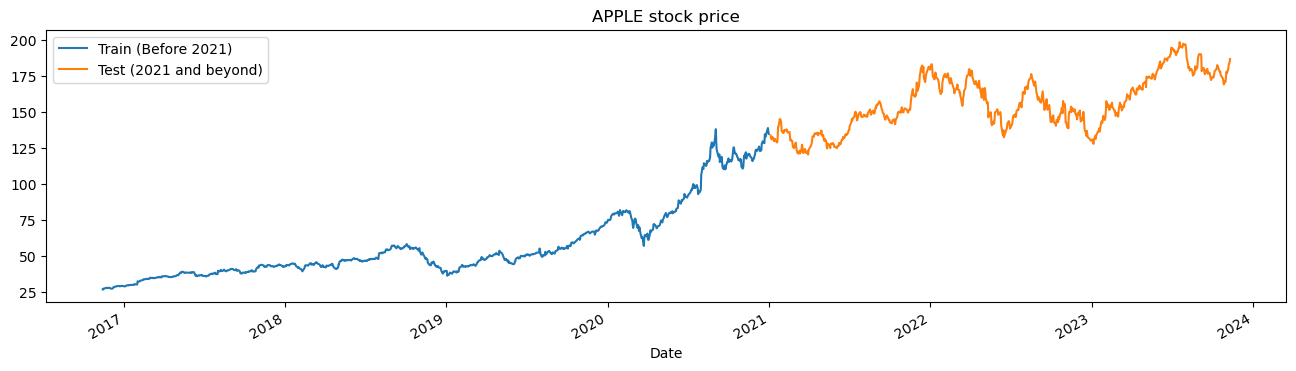

In [36]:

tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)


In [37]:

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(dataset, tstart, tend)


In [38]:

# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)


In [53]:

def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)


In [57]:
y_train

array([[0.05644946],
       [0.05841604],
       [0.06125413],
       [0.06389114],
       [0.06306426],
       [0.06290785],
       [0.0649638 ],
       [0.06579064],
       [0.06659515],
       [0.06476268],
       [0.06650577],
       [0.06650577],
       [0.07256189],
       [0.07285242],
       [0.07184679],
       [0.07171272],
       [0.07218199],
       [0.07177975],
       [0.06952265],
       [0.07079647],
       [0.07095288],
       [0.07144452],
       [0.07390275],
       [0.07450614],
       [0.07446143],
       [0.0755788 ],
       [0.07848397],
       [0.07580229],
       [0.07575758],
       [0.07611515],
       [0.07495308],
       [0.08125502],
       [0.08226068],
       [0.08228301],
       [0.08176903],
       [0.0814338 ],
       [0.08315456],
       [0.08442837],
       [0.08232772],
       [0.08156788],
       [0.08089749],
       [0.07971308],
       [0.07703137],
       [0.07754538],
       [0.07642801],
       [0.07678554],
       [0.07669617],
       [0.078

In [40]:

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


### LSTM Prediction

In [41]:
# Define Model Architecture

model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(window_size, features)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 125)               63500     
                                                                 
 dense_4 (Dense)             (None, 25)                3150      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 66676 (260.45 KB)
Trainable params: 66676 (260.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:

model_lstm.fit(X_train, y_train, epochs=15, batch_size=32)


Epoch 1/15
31/31 [==============================] - 2s 26ms/step - loss: 0.0046
Epoch 2/15
31/31 [==============================] - 1s 26ms/step - loss: 4.6812e-04
Epoch 3/15
31/31 [==============================] - 1s 26ms/step - loss: 3.9442e-04
Epoch 4/15
31/31 [==============================] - 1s 26ms/step - loss: 3.8387e-04
Epoch 5/15
31/31 [==============================] - 1s 26ms/step - loss: 4.3933e-04
Epoch 6/15
31/31 [==============================] - 1s 26ms/step - loss: 3.5261e-04
Epoch 7/15
31/31 [==============================] - 1s 26ms/step - loss: 3.6198e-04
Epoch 8/15
31/31 [==============================] - 1s 26ms/step - loss: 3.2334e-04
Epoch 9/15
31/31 [==============================] - 1s 26ms/step - loss: 3.2386e-04
Epoch 10/15
31/31 [==============================] - 1s 26ms/step - loss: 3.4733e-04
Epoch 11/15
31/31 [==============================] - 1s 26ms/step - loss: 3.3585e-04
Epoch 12/15
31/31 [==============================] - 1s 32ms/step - loss: 3.14

In [43]:

dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)


In [44]:

X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)


23/23 [==============================] - 0s 8ms/step


In [45]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))
    

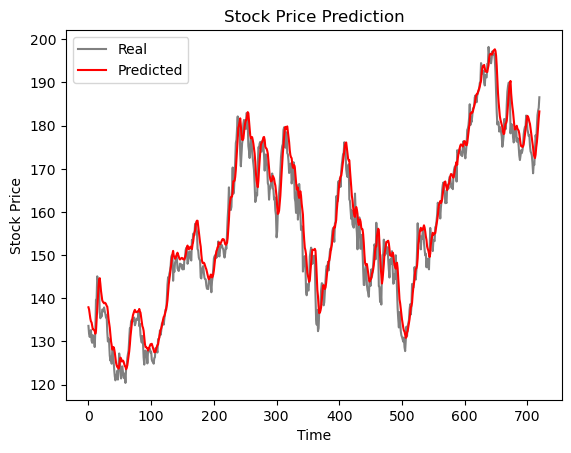

In [46]:

plot_predictions(y_test,predicted_stock_price)


In [47]:

return_rmse(y_test,predicted_stock_price)


The root mean squared error is 3.74.


### GRU

In [48]:
# Define model architecture

model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 125)               48000     
                                                                 
 dense_6 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:

X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

model_gru.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
31/31 [==============================] - 1s 22ms/step - loss: 0.0180
Epoch 2/10
31/31 [==============================] - 1s 22ms/step - loss: 6.2876e-04
Epoch 3/10
31/31 [==============================] - 1s 22ms/step - loss: 2.8079e-04
Epoch 4/10
31/31 [==============================] - 1s 22ms/step - loss: 2.6462e-04
Epoch 5/10
31/31 [==============================] - 1s 23ms/step - loss: 2.6648e-04
Epoch 6/10
31/31 [==============================] - 1s 23ms/step - loss: 2.5581e-04
Epoch 7/10
31/31 [==============================] - 1s 24ms/step - loss: 2.6320e-04
Epoch 8/10
31/31 [==============================] - 1s 24ms/step - loss: 2.4779e-04
Epoch 9/10
31/31 [==============================] - 1s 24ms/step - loss: 2.4103e-04
Epoch 10/10
31/31 [==============================] - 1s 23ms/step - loss: 2.4043e-04


In [50]:

GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
y_test = sc.inverse_transform(y_test)


23/23 [==============================] - 0s 6ms/step


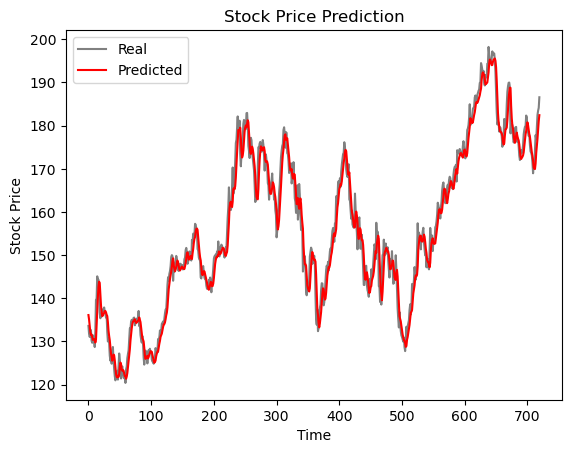

In [51]:

plot_predictions(y_test, GRU_predicted_stock_price)


In [52]:

return_rmse(y_test,GRU_predicted_stock_price)


The root mean squared error is 3.15.
